# Title


If you are not familiar with PyMC, you can [start with this chapter from *Think Bayes*](https://allendowney.github.io/ThinkBayes2/chap19.html), especially the World Cup Problem. Or you can [run that chapter on Colab](https://colab.research.google.com/github/AllenDowney/ThinkBayes2/blob/master/notebooks/chap19_v3.ipynb).

You can read [the slides I used to present this example](COMING SOON).

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/SurveyDataPyMC/blob/main/notebooks/01_tutorial.ipynb)

In [2]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
  
download('https://github.com/AllenDowney/SurveyDataPyMC/raw/main/notebooks/utils.py')

In [3]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from utils import decorate, value_counts

In [5]:
# Make the figures smaller to save some screen real estate

plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.figsize'] = [6, 3.5]
plt.rcParams['axes.titlelocation'] = 'left'

In [6]:
# Get the GSS data

# This dataset is prepared in GssExtract/notebooks/02_make_extract-2022_3a.ipynb

DATA_PATH = "https://github.com/AllenDowney/GssExtract/raw/main/data/interim/"
filename = "gss_extract_2022_3a.hdf"
download(DATA_PATH + filename)

In [7]:
gss = pd.read_hdf(filename, "gss")
gss.shape

(72390, 57)

In [8]:
# https://gssdataexplorer.norc.org/variables/452/vshow

question = """Taken all together, how would you say things are these days--
would you say that you are very happy, pretty happy, or not too happy?
"""

# 1 = very happy
# 2 = pretty happy
# 3 = not too happy

title = "Are you happy?"
subtitle = "Percent saying very happy"
ylim = [10, 45]

In [9]:
value_counts(gss['happy'])

,counts
values,
1.0,21550
2.0,37446
3.0,8681
NaN,4713


In [10]:
missing = gss['happy'].isna()
gss['y'] = (gss['happy'] == 1).astype(float).mask(missing)
value_counts(gss['y'])

,counts
values,
0.0,46127
1.0,21550
NaN,4713


In [11]:
gss2022 = gss.query('year == 2022').dropna(subset=['sex', 'happy'])
gss2022.shape

(3523, 58)

In [12]:
gss2022["sex"].value_counts()

sex
2.0    1785
1.0    1738
Name: count, dtype: int64

In [13]:
gss2022.groupby('sex')['y'].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
1.0,1738.0,0.234177,0.423605,0.0,0.0,0.0,0.0,1.0
2.0,1785.0,0.249860,0.433053,0.0,0.0,0.0,0.0,1.0


In [14]:
X = gss2022['sex'].values - 1
y = gss2022['y'].values

In [78]:
with pm.Model() as logistic_model:
    # Priors for the coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sigma=10)

    # Linear combination of coefficients and independent variables
    logit_p = intercept + beta_sex * X

    # Link function (sigmoid)
    p = pm.math.sigmoid(logit_p)

    # observed data
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y)

In [78]:
with pm.Model() as logistic_model:
    # Priors for the coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sigma=10)

    # Linear combination of coefficients and independent variables
    logit_p = intercept + beta_sex * X

    # observed data
    y_obs = pm.Bernoulli('y_obs', logit_p=logit_p, observed=y)

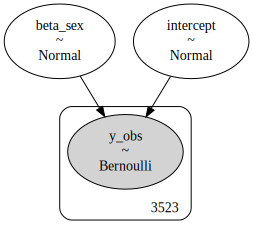

In [79]:
pm.model_to_graphviz(logistic_model)

First we'll sample from the prior and prior predictive distributions.

In [80]:
with logistic_model:
    idata_prior = pm.sample_prior_predictive()

Sampling: [beta_sex, intercept, y_obs]


<Axes: >

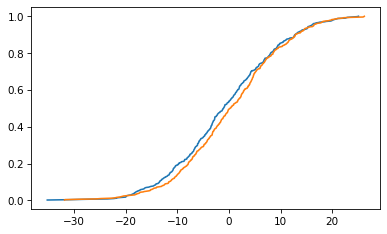

In [81]:
from empiricaldist import Cdf

beta_sex = idata_prior.prior['beta_sex'].values.flatten()
intercept = idata_prior.prior['intercept'].values.flatten()

Cdf.from_seq(beta_sex).plot()
Cdf.from_seq(intercept).plot()

<Axes: >

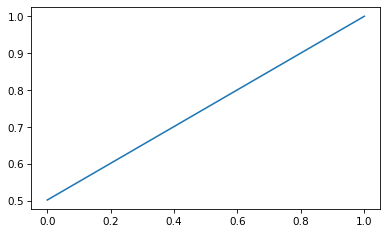

In [82]:
y_obs = idata_prior.prior_predictive['y_obs'].values.flatten()
Cdf.from_seq(y_obs).plot()

In [83]:
with logistic_model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_sex]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [85]:
pm.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-1.184,0.056,-1.287,-1.074,0.002,0.001,1237.0,1587.0,1.0
beta_sex,0.082,0.079,-0.074,0.221,0.002,0.002,1174.0,1707.0,1.0


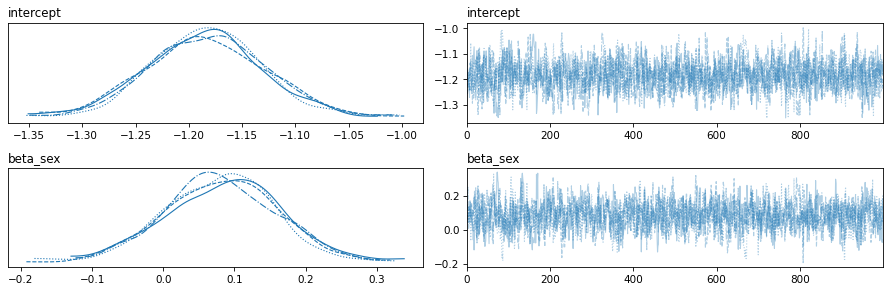

In [86]:
pm.plot_trace(idata)
plt.tight_layout()

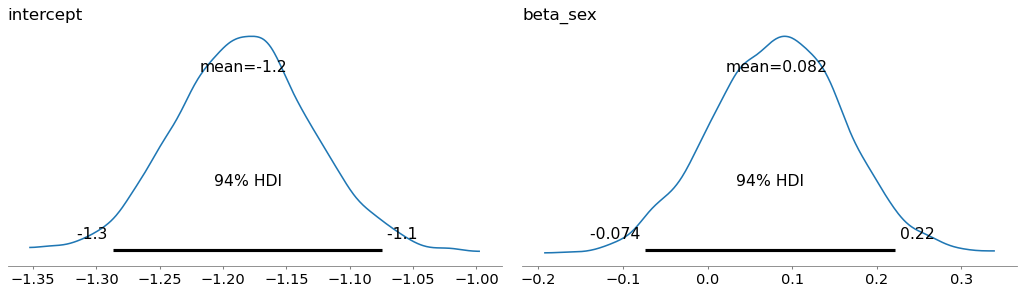

In [87]:
pm.plot_posterior(idata)
plt.tight_layout()

In [24]:
def get_sample(idata, var_name):
    """Extract a posterior sample from idata
    
    idata: InferenceData object
    var_name: string
    
    returns: NumPy array
    """
    return idata.posterior[var_name].values.flatten()

In [25]:
from scipy.special import expit

intercepts = get_sample(idata, 'intercept')
ps = expit(intercepts)

np.mean(ps), np.percentile(ps, [3, 97])

(0.2341730213763489, array([0.21543519, 0.25307751]))

In [26]:
betas = get_sample(idata, 'beta_sex')
ps = expit(intercepts + betas)

np.mean(ps), np.percentile(ps, [3, 97])

(0.25020538738940623, array([0.23078182, 0.26947407]))

## Contour plots

To show the relationship between elapsed time and arrival rate, let's make a contour plot of their joint distribution.

In [27]:
from scipy.stats import gaussian_kde

def joint_contour(x, y):
    data = np.vstack([x, y])
    kde = gaussian_kde(data)

    xs = np.linspace(x.min(), x.max(), 101)
    ys = np.linspace(y.min(), y.max(), 101)
    X, Y = np.meshgrid(xs, ys, indexing='ij')

    positions = np.vstack([X.ravel(), Y.ravel()])
    kde_values = kde(positions).reshape(X.shape)

    plt.contour(X, Y, kde_values, cmap='Blues')

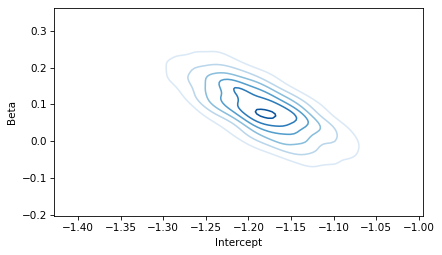

In [28]:
joint_contour(intercepts, betas)
decorate(xlabel='Intercept', ylabel='Beta')

## Ordered Logistic Regression

First attempt, using OrderedLogistic likelihood

In [60]:
gss2022 = gss.query('year == 2022').dropna(subset=['sex', 'happy'])

In [61]:
gss2022['happy'].value_counts().sort_index()

happy
1.0     853
2.0    1943
3.0     727
Name: count, dtype: int64

In [62]:
# shift so 0=male, 1=female
X = gss2022['sex'].values - 1
pd.Series(X).value_counts()

1.0    1785
0.0    1738
Name: count, dtype: int64

In [64]:
# flip so it's encoded 0=not very happy, 1=pretty happy, 2=very happy
data = 3 - gss2022['happy'].values
pd.Series(data).value_counts().sort_index()

0.0     727
1.0    1943
2.0     853
Name: count, dtype: int64

In [75]:
with pm.Model() as ordered_logistic_model:
    
    # Priors for the coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=2)
    beta_sex = pm.Normal('beta_sex', mu=0, sigma=2)
    
    # Priors for the cutpoints (thresholds) between categories
    cutpoints = pm.Normal('cutpoints', mu=np.array([-1, 1]), sigma=2, shape=2,
                          transform=pm.distributions.transforms.ordered)
    
    # Linear combination of coefficients and independent variables
    eta = intercept + beta_sex * X
    
    # Likelihood: ordered logistic regression
    y_obs = pm.OrderedLogistic('y_obs', eta=eta, cutpoints=cutpoints, 
                               compute_p=False, observed=data)

In [76]:
with ordered_logistic_model:
    idata = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_sex, cutpoints]


Output()

/home/downey/miniconda3/envs/SurveyDataPyMC/lib/python3.12/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 156 seconds.


In [77]:
pm.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.083,1.186,-2.038,2.402,0.039,0.029,920.0,951.0,1.01
beta_sex,0.044,0.066,-0.077,0.170,0.002,0.002,1316.0,1198.0,1.00
cutpoints[0],-1.242,1.187,-3.408,1.021,0.039,0.029,915.0,945.0,1.01
cutpoints[1],1.246,1.185,-0.800,3.604,0.039,0.028,916.0,908.0,1.01


## Ordered Logistic Regression

Version 2: Computing the probabilities explicitly and using Categorical

In [73]:
with pm.Model() as ordered_logistic_model:
    
    # Priors for the coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=3)
    beta_sex = pm.Normal('beta_sex', mu=0, sigma=3)
    
    # Priors for the cutpoints (thresholds) between categories
    cutpoints = pm.Normal('cutpoints', mu=np.array([-1, 1]), sigma=2, shape=2,
                          transform=pm.distributions.transforms.ordered)
    
    # Linear combination of coefficients and independent variables
    eta = intercept + beta_sex * X
    
    # Scaling parameter for sigmoid
    kappa = 0.5
    
    # Calculate cumulative probabilities for the three categories
    # P(y <= 1), P(y <= 2), and implicitly P(y <= 3) = 1
    p1 = pm.math.sigmoid(kappa * (cutpoints[0] - eta))
    p2 = pm.math.sigmoid(kappa * (cutpoints[1] - eta))
    
    # Probabilities for each category (P(y = 1), P(y = 2), P(y = 3))
    p_y1 = p1
    p_y2 = p2 - p1
    p_y3 = 1 - p2
    
    # Combine probabilities into a matrix (each row sums to 1)
    p = pm.math.stack([p_y1, p_y2, p_y3], axis=1)
    
    # Likelihood: categorical distribution for the observed data
    y_obs = pm.Categorical('y_obs', p=p, observed=data)
        
    idata = pm.sample(500)

Output()

/tmp/ipykernel_2835158/719620894.py:35: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  idata = pm.sample(500, start=start)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_sex, cutpoints]


Output()

/home/downey/miniconda3/envs/SurveyDataPyMC/lib/python3.12/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/home/downey/miniconda3/envs/SurveyDataPyMC/lib/python3.12/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 128 seconds.


In [74]:
pm.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.038,1.272,-2.130,2.585,0.042,0.031,915.0,1090.0,1.01
beta_sex,0.038,0.063,-0.090,0.147,0.002,0.001,1029.0,1008.0,1.01
cutpoints[0],-1.292,1.271,-3.557,1.139,0.042,0.032,919.0,1089.0,1.01
cutpoints[1],1.198,1.272,-1.054,3.635,0.042,0.030,923.0,1029.0,1.00


## Ordered Logistic Regression

Version 3: computing counts in each category and using Multinomial

This works, which confirms that the priors I'm using are reasonable -- so I still don't see why the previous versions don't sample!

In [ ]:
gss2022 = gss.query('year == 2022').dropna(subset=['sex', 'happy'])

In [ ]:
xtab = pd.crosstab(gss2022['sex'], gss2022['happy'])
X = xtab.index.values
X

In [ ]:
counts = xtab.values
counts

In [ ]:
with pm.Model() as multinomial_model:
    # Priors for the coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=3)
    beta_sex = pm.Normal('beta_sex', mu=0, sigma=3)
    
    # Priors for the cutpoints (thresholds) between categories
    cutpoints = pm.Normal('cutpoints', mu=np.array([-2, 2]), sigma=2, shape=2,
                          transform=pm.distributions.transforms.ordered)
    
    # Linear combination of coefficients and independent variables
    eta = intercept + beta_sex * X
    
    # Adjusted cumulative probabilities using sigmoid
    p1 = pm.math.sigmoid(cutpoints[0] - eta)
    p2 = pm.math.sigmoid(cutpoints[1] - eta)
    
    # Probabilities for each category (P(y = 1), P(y = 2), P(y = 3))
    p_y1 = p1
    p_y2 = p2 - p1
    p_y3 = 1 - p2
    
    # Stack probabilities to get the probability vector for each observation
    p = pm.math.stack([p_y1, p_y2, p_y3], axis=1)
    
    # Likelihood: multinomial distribution for the aggregated counts
    y_obs = pm.Multinomial('y_obs', n=counts.sum(axis=1), p=p, observed=counts)
    
    # Sampling
    idata = pm.sample(500)

In [ ]:
# Summary of the posterior distribution
pm.summary(idata)